# UTILS

In [1]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick an image that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        
        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
        
    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))

def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    # plt.plot(H.history["accuracy"], label="train_acc")
    # plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

# SIAMESE NETWORK

In [2]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

def build_siamese_model(inputShape, embeddingDim=48):
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    
    
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

# CONFIG

In [3]:
# import the necessary packages
import os

# specify the shape of the inputs for our network
IMG_SHAPE = (28, 28, 1)

# specify the batch size and number of epochs
BATCH_SIZE = 128
EPOCHS = 20

# define the path to the base output directory
BASE_OUTPUT = "Contrastive_Loss_output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# TRAINING

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...
[INFO] building siamese network...


In [5]:
print(pairTrain.shape, labelTrain.shape)
print(pairTest.shape, labelTest.shape)
pairTrain = pairTrain[:15000,]
labelTrain = labelTrain[:15000,]
pairTest = pairTest[:2500]
labelTest = labelTest[:2500]
print(pairTrain.shape, labelTrain.shape)
print(pairTest.shape, labelTest.shape)

(120000, 2, 28, 28, 1) (120000, 1)
(20000, 2, 28, 28, 1) (20000, 1)
(15000, 2, 28, 28, 1) (15000, 1)
(2500, 2, 28, 28, 1) (2500, 1)


[INFO] compiling model...
[INFO] training model...
Epoch 1/5
235/235 [==============================] - 31s 133ms/step - loss: 0.2348 - val_loss: 0.2280
Epoch 2/5
235/235 [==============================] - 37s 155ms/step - loss: 0.2088 - val_loss: 0.1946
Epoch 3/5
235/235 [==============================] - 36s 153ms/step - loss: 0.1995 - val_loss: 0.1903
Epoch 4/5
235/235 [==============================] - 35s 148ms/step - loss: 0.1973 - val_loss: 0.1874
Epoch 5/5
235/235 [==============================] - 36s 152ms/step - loss: 0.1947 - val_loss: 0.1842
[INFO] saving siamese model...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Contrastive_Loss_output\siamese_model\assets
[INFO] plotting training history...


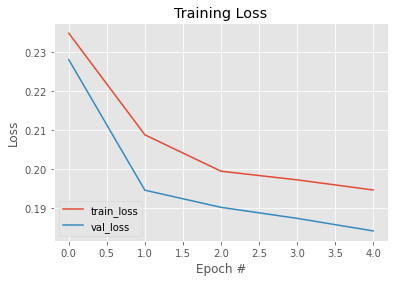

In [6]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

# import the necessary packages
import tensorflow.keras.backend as K
import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

# compile the model
print("[INFO] compiling model...")

model.compile(loss=contrastive_loss, optimizer="adam")
    
# model.compile(loss="cross-entropy", optimizer="adam", metrics=["accuracy"])
    

# train the model
print("[INFO] training model...")
history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=64, 
    epochs=5)

# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)

# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)